# StockPredictor Tutorial

In [ ]:
import torch
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta

from rnn import LSTM

Select stocks to create predictions for

In [ ]:
symbols = ['AAPL', 'AMZN']      # stocks to make predictions for
device = 'cuda:0'               # device to use; cuda or cpu
steps = 25                      # future time steps to predict for

Create predictions for each stock

In [ ]:
# Load model
kwargs, state = torch.load('models/rnn/weights/best.pth', map_location=torch.device(device))
model = LSTM(**kwargs)
model.load_state_dict(state)
model.to(device)
model.eval()

# List to store predictions
outputs = []

# Create predictions for each stock
for _, stock in enumerate(symbols):
    stock = stock.replace('.', '-')   # format ticker symbol

    predictions = torch.rand(1,0,5)   # tensor to store future predictions

    # Send empty tensor to device
    if 'cuda' in device:
        predictions = predictions.cuda()

    # Format datetimes to download most recent daat from Yahoo Finance
    now = dt.datetime.now()
    a = dt.datetime(1970,1,1,23,59,59)
    b = dt.datetime(now.year, now.month, now.day, 23, 59, 59)
    c = b - relativedelta(years=5)

    period1 = str(int((c-a).total_seconds()))   # total seconds from today since Jan. 1, 1970 subracting 5 years
    period2 = str(int((b-a).total_seconds()))   # total seconds from today since Jan. 1, 1970

    # Download data
    data = pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/{x}?period1={period1}&period2={period2}&interval=1d&events=history&includeAdjustedClose=true'.format(x=stock, period1=period1,period2=period2))
    x = data[['Open', 'High', 'Low', 'Volume', 'Close']]   # input data

    mins, maxs = x.min(), x.max()   # values for normalization

    # Normalize inputs
    x = (x-mins)/(maxs-mins)
    x = torch.tensor(x.values)
    x = torch.unsqueeze(x, dim=0)
    
    mins = torch.tensor(mins.values)
    maxs = torch.tensor(maxs.values)

    # Send inputs to device
    if 'cuda' in device:
        x, mins, maxs = x.cuda(), mins.cuda(), maxs.cuda()

    # Make predicitons for n time steps
    for _ in range(steps):
        pred = model(x.float())   # model prediction for one time step
        pred = torch.unsqueeze(pred, dim=0)
        
        predictions = torch.cat((predictions, pred), dim=1)   # append predicition to full predictions tensor

        x = torch.cat((x, pred), dim=1)   # append predicition to input data for next time step

    # Unnormalize predictions and send to DataFrame
    predictions = predictions*(maxs-mins)+mins
    predictions = pd.DataFrame(predictions.cpu().squeeze().detach().numpy(), columns=['Open', 'High', 'Low', 'Volume', 'Close'])

    # Append DataFrame to list
    outputs.append(pd.concat([data, predictions], ignore_index=True))

Plot 5 years worth of data and predictions

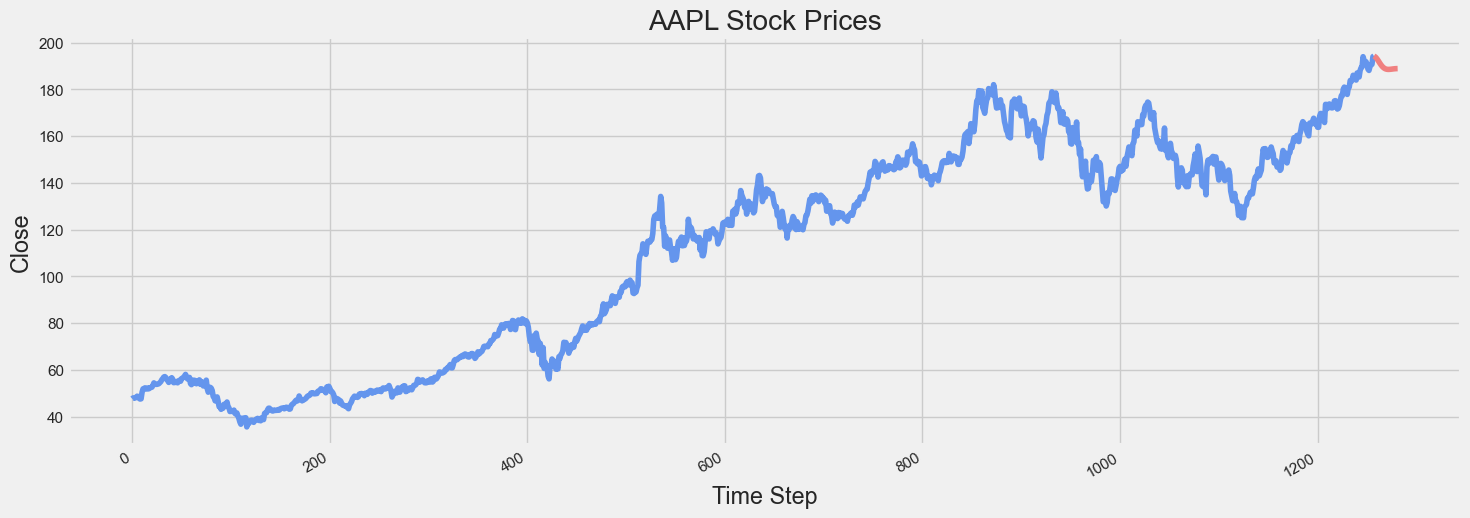

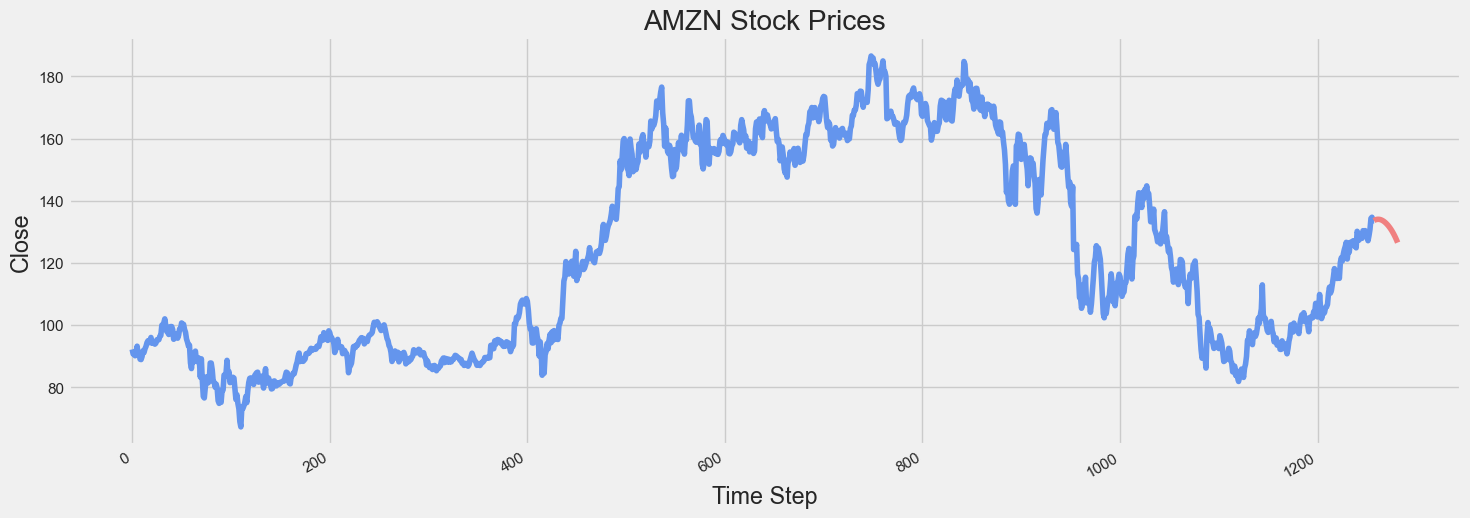

In [22]:
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

# Plot each stock
for i, x in enumerate(outputs):
    plt.figure(figsize=(16, 6))
    plt.title("{x} Stock Prices".format(x=symbols[i]))
    plt.gcf().autofmt_xdate()
    plt.ylabel("Close")
    plt.xlabel("Time Step")
    plt.xlim([1000, 1300])
    plt.plot(x.loc[0:1257, "Close"], color='cornflowerblue')
    plt.plot(x.loc[1257:,"Close"], color='lightcoral')
    plt.show()